0.5
RIGOL TECHNOLOGIES,DS1054Z,DS1ZA192409533,00.04.04.SP3


<ipython-input-18-8e879150d42c>:239: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('Waveform and Eye Diagram')


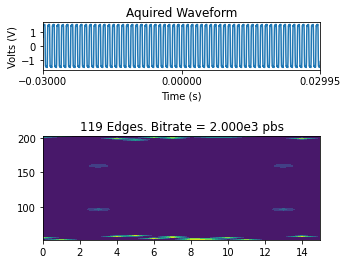

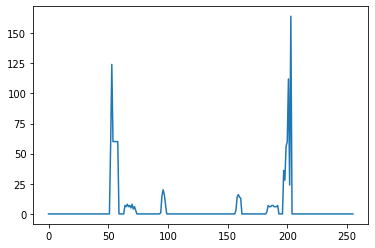

In [18]:
"""
Eye builder for DPO2000/3000/4000

Built using
python 2.7.1          (http://www.python.org/)
pyvisa 1.3          (http://pypi.python.org/pypi/PyVISA/1.3)
MatPlotLib 1.0.1    (http://matplotlib.sourceforge.net/)
Numpy               (http://numpy.scipy.org/)

The Eye2 function has the following arguments
scope - instrument resource configured with PyVISA
source - Any channel form the Oscillsocope CH1-4,MATH,REF1-4
Clock Recovery - None: NO clock recovery. Will use detected edges for right side
                 CC:  Constanc clock, using first edge and frequncy of bitrate
                 PLL: Phase Lock Loop using Bitrate and selectable
Drsel   - Data rate, either Auto detect, or pass as a float
BWsel   - Loop bandwidth for PLL.  Either auto set as 1/2 data rate, or pass
            value to use as a float

Eye2 function will be called when this program is run as the root.  The
instrument identifer is selected in this part of the script, and needs
to be a valid resource as found by VISA.

Eye2 function uses the MakeSci function for formating numbers to display
and WaveformSetup to set/get settings for curve data transfer and
conversion to volts.  The WaveFormSetup function is set to work with
TDS200/2000/30000 series, DPO2000/3000/4000 seires scopes.
Requires either TekVISA or NIVISA to be installed
"""

import matplotlib.mlab
import matplotlib.pylab
import numpy as np
from struct import unpack
from ds1054z import DS1054Z
import math
import struct

def Eye2(scope, source='CH1', ClockRecovery = 'None',\
         DRsel = 2e3, BWsel = 'Auto Set'):
    # setup scope and get curve data
    [recLen,  HPos, xincr, HDelay, yoff, ymult, yzero] =  WaveFormSetup(scope)
    #scope.write('data:sou ' + source)
    #scope.write('SEL:' + source + ' ON')
    histo = list(range(256))
    for a in list(range(len(histo))):
        histo[a] = 0
    #recLenNumBytes = len(recLen)
    #headerLen = 1 + 1 + recLenNumBytes
    #scope.write('curve?')
    buff = scope.get_waveform_bytes(1)
    #wave = wave[headerLen:(int(recLen)-1)]
    #wave = unpack('%sB' % len(wave),wave)

    fmt, typ, pnts, cnt, xincr, xorig, xref, yinc, yorig, yref = scope.waveform_preamble
    wave = list(struct.unpack(str(len(buff))+'B', buff))

    #make x, y for the waveform plot
    x = np.arange(len(wave))
    y = np.arange(len(wave))
    for a in (range(len(wave))):
        y[a] = wave[a]
    samples = [(val - yorig - yref)*yinc for val in wave]
    yvolt = samples
    if scope.mask_begin_num:
        at_begin = scope.mask_begin_num[0]
        num = scope.mask_begin_num[1]
        if at_begin:
            samples = [float('nan')] * num + samples[num:]
        else:
            samples = samples[:-num] + [float('nan')] * num
    x = scope.waveform_time_values
    # build a 1d histrogram
    for a in wave:
        histo[a] = histo[a] + 1
    # find the range where data starts and stops in histogram
    for a in range(256):
        if histo[a] != 0:
            start = a
            break
    for a in range(255, 0, -1):
        if histo[a] != 0:
            stop = a
            break
    # Deteremine the range of data, and define threshholds
    mid = int((start + stop) / 2)
    high = histo.index(max(histo[mid:stop]))
    low = histo.index(max(histo[start:mid]))
    waverange = high - low
    mid = (high + low) / 2 
    lowthresh = .3 * waverange + low
    highthresh = .7 * waverange + low
    #Find Edges
    var1 = []
    gtmid = y > mid
    gthigh = y > highthresh
    gtlow = y  < lowthresh
    temp = gtmid[0]
    cross = False
    for a in range(len(gtmid)):
        if cross == False:
            if temp != gtmid[a]:
                temp = gtmid[a]
                var1.append(a)
                cross = True
        else:
            if cross == gthigh[a] or cross == gtlow[a]:
                cross = False
  

    edges = len(var1)
    # make array of differences  between 
    var2 = []
    for a in range(len(var1)):
        try:
            var2.append(var1[a+1] - var1[a])
        except:
            pass
    # Verify that enough cycles are present to contruct the eye
    if len(var2) < 4:
        print ('Not enough Cycles to Contruct Eye')
        return
    # Deteremine the bitrate.
    if DRsel == 'Auto Detect':
        glitch = int(len(var2) / 10)
        if glitch < 1:
            glitch = 1
        var3 = var2
        var4 = []
        var3.sort()
        while True:
            for a in var3:
                if a <= (var3[0] * 1.2):
                    var4.append(a)
            if len(var4) > glitch:
                bitave = float(sum(var4) / len(var4))
                break
            else:
                var3 = var3[1:]
        bitrate = 1 / (bitave * xincr)
        bitave = int(bitave)
    else:
        bitrate = float(DRsel)
        bitave = int(1 / (bitrate * xincr))
    # Generate edges for clock recovery, constant clock
    if ClockRecovery == 'CC':
        fullrclock = []
        rclock = []
        for i in range(int(float(recLen)*float(xincr) * float(bitrate))):
            fullrclock.append(var1[0] + i * bitave)
        swing = int(1 / (float(bitrate) * float(xincr) * 4))
        for a in var1:    # find coresponding edges to rclock edges
            for b in range(len(fullrclock)):
                diff = abs(fullrclock[b] - a)
                if (swing > diff):
                    rclock.append(fullrclock[b])
                    break
        
    elif ClockRecovery == 'None':
        rclock = var1
    elif ClockRecovery == 'PLL':
        # start with constant clock recovery
        fullrclock = []
        rclock = []
        for i in range(int(float(recLen)*float(xincr) * float(bitrate))):
            fullrclock.append(var1[0] + i * bitave)
        # find max swing from rclock to be within 2/3 of UI
        swing = float(1 / (float(bitrate) * float(xincr) * 1.5))
        if BWsel == 'Auto Set':
             #BW filter is 1/4 data rate by default
            loopBW = float(1 / (float(bitrate) * float(xincr) * 2))  
            if loopBW < 2:
                print ('Error: Sample rate too slow to use PLL')
                return
        else:
            loopBW = float(bitave * float(BWsel)/bitrate)
        for a in var1:    # find coresponding edges to rclock edges
            for b in range(len(fullrclock)):
                diff = abs(fullrclock[b] - a)
                if (swing >= diff):#when found, filter diff and apply to rclock
                    if diff != 0:
                        filtdif = int(diff * \
                                abs(1 / (1 + ((diff/loopBW)**2*1j))))                            
                        if fullrclock[b] > a:
                            sign = -1
                        else:
                            sign = 1
                        for d in range(b, len(rclock), 1):
                            fullrclock[d] = fullrclock[d] + sign * filtdif
                        rclock.append(fullrclock[b]+ sign * filtdif)
                    else:
                        rclock.append(fullrclock[b])
                    break
        
        
    #Generate 2d histogram of the eye
    padsize = int(.3 * bitave)
    windowlength = int(bitave + 2 * padsize)
    eye = np.zeros((256, windowlength))
    for b in range(len(rclock)):
        windowstart = rclock[b]- padsize
        windowstop = rclock[b] + int(bitave + padsize)
        window = wave[windowstart:windowstop]
        for a in range(len(window)-1):
            eye[window[a],a] = eye[window[a],a] + 1

        

    # deteremine jitter at the corssings
    try:
        midhisto = np.zeros((windowlength))
        for a in range(windowlength):
            for b in range(mid -5, mid + 5, 1):
                midhisto[a] = midhisto[a] + eye[b, a]
        for a in range(windowlength/2):
            if midhisto[a] != 0:
                start1 = a
                break
        for a in range(windowlength/2-1, 1, -1):
            if midhisto[a] != 0:
                stop1 = a
                break
        for a in range(windowlength/2 ,windowlength,1):
            if midhisto[a]!= 0:
                start2 = a
                break
        for a in range(windowlength-1, windowlength/2, -1):
             if midhisto[a] != 0:
                stop2 = a
                break
        jit1 = stop1 - start1
        jit2 = stop2 - start2
    except:
        pass
   
        
    # Configure ploting the aquired waveform and eye diagram
    fig = matplotlib.pylab.figure()
    fig.canvas.set_window_title('Waveform and Eye Diagram')
    ax1 = matplotlib.pylab.subplot2grid((4,6),(0,0), rowspan=1, colspan = 5)
    ax2 = matplotlib.pylab.subplot2grid((4,6),(2,0), rowspan=3, colspan = 5)
    ax1.plot(x,yvolt)
    ax1.set_ylabel('Volts (V)')
    ax1.set_xlabel('Time (s)')
    ax1.set_title('Aquired Waveform')
    xaxis1 = [x[0], x[int(len(x)/2)], x[-1]]
    ax1.set_xticks(xaxis1)
    ax1.set_xlim(x[0],x[len(x)-1])
    yaxis2 = [low, mid, high]
    ylabels2 = [1,2,3]
    ax2.set_title(str(len(var1)) + ' Edges. Bitrate = ' + MakeSci(bitrate) + \
                  ' pbs')
    ax2.set_ylim(start, stop)
    #ax2.set_yticks(yaxis2,ylabels2)
    ax2.contourf(eye)
    try:
        jitter1 = MakeSci(jit1 * xincr) + 's p-p'
        jitter2 = MakeSci(jit2 * xincr) + 's p-p'
        ax2.text(stop1, mid, 'J1 = ' + jitter1,\
                bbox={'facecolor':'white', 'alpha':.6, 'pad':10})
        ax2.text(stop2, mid, 'J2 = ' + jitter2, \
                bbox={'facecolor':'white', 'alpha':.6, 'pad':10})
    except:
        pass
    matplotlib.pylab.show()
    fig2 = matplotlib.pylab.figure()
    matplotlib.pyplot.plot(list(range(256)),histo)
    matplotlib.pylab.show()



def MakeSci(number):
    if number != 0:
        for exponent in (-15, -12, -9, -6, -3, 0, 3, 6, 9, 12):
            flt = number * math.pow(10, exponent)
            if (int(flt) > 0) and int(flt) < 1000:
                answer = '%.3fe%d' % (round(flt, 2), (exponent*-1))
    return answer

def WaveFormSetup(scope):
    scopename = scope.ask("*IDN?").split(',')
    filename = scopename[1] + '_' + scopename[2] +'_'
    scope.display_only_channel(1)
    ch1off = False
    scope.write('DATA:SOUR CH1')
    recLen = scope.memory_depth#scope.ask("horizontal:recordlength?")
    Hscale = scope.timebase_scale
    HDelay = scope.timebase_offset
    HPos = 0
    xincr = 0
    yoff = 0
    ymult = 0
    yzero = 0
    
    
    '''
    if 'TDS 21' in scopename[1] or 'TDS 22' in scopename[1]:
        Hscale = float(scope.ask("HOR:SCA?"))
        HDelay = float(scope.ask("HORizontal:DELay:POSITION?"))
        HPos = float((Hscale * 5 + float(scope.ask("HORIZONTAL:POSITION?")))/ \
                     (Hscale * 10) * 100)
        xincr = float(scope.ask("wfmpre:xincr?"))
        ymult = float(scope.ask("wfmpre:ymult?"))
        yoff = float(scope.ask("wfmpre:yoff?"))
        yzero = float(scope.ask("wfmpre:yzero?"))
       
    elif 'TDS' in scopename[1] and  '20'  in scopename[1]:
        Hscale = float(scope.ask("HOR:SCA?"))
        HDelay = float(scope.ask("HORizontal:DELay:POSITION?"))
        HPos = float((Hscale * 5 + float(scope.ask("HORIZONTAL:POSITION?")))/ \
                     (Hscale * 10) * 100)
        xincr = float(scope.ask("wfmpre:xincr?"))
        ymult = float(scope.ask("wfmpre:ymult?"))
        yoff = float(scope.ask("wfmpre:yoff?"))
        yzero = float(scope.ask("wfmpre:yzero?"))
    elif 'DPO' in scopename[1] or 'MSO' in scopename[1]:
        Hscale = float(scope.ask("HOR:SCA?"))
        HDelay = float(scope.ask("HORizontal:DELay:TIMe?"))
        HPos = float(scope.ask("HORIZONTAL:POSITION?"))
        xincr = float(scope.ask("wfmo:xincr?"))
        ymult = float(scope.ask("wfmo:ymult?"))
        yoff = float(scope.ask("wfmo:yoff?"))
        yzero = float(scope.ask("wfmo:yzero?"))
        if '20' in scopename[1]:
            recLen = scope.ask("wfmo:nr_pt?")
            if str(scope.ask("DATA:COMP?")) != "COMPOSITE_YT":
                scope.write("DATA:COMP COMPOSITE_YT")                               
    elif 'TDS' in scopename[1] and '30' in scopename[1]:
        Hscale = float(scope.ask("HOR:SCA?"))
        HDelay = float(scope.ask("HORizontal:DELay:TIME?"))
        HPos = float((Hscale * 5 + float(scope.ask("HORIZONTAL:DELay:TIME?")))/ \
                     (Hscale * 10) * 100)
        xincr = float(scope.ask("wfmpre:xincr?"))
        ymult = float(scope.ask("wfmpre:ymult?"))
        yoff = float(scope.ask("wfmpre:yoff?"))
        yzero = float(scope.ask("wfmpre:yzero?"))
        scope.write("wfmoutpre:bit_nr 8")
    '''
    #Generic all model configure the scope hardcopy settings
    #scope.write("header off")
    #scope.write("VERBOSE OFF")
    #scope.write("data:start 1;stop " + recLen + \
    #            ";:data:encdg rpbinary");
    #if ch1off == True:
    #    scope.write('SEL:CH1 OFF')
    return recLen,  HPos, xincr, HDelay, yoff, ymult, yzero


if __name__ == "__main__":
    scope = DS1054Z('192.168.1.252')
    print(scope.get_channel_scale(1))
    print(scope.idn)
    Eye2(scope)
    